In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
#KULLANACAĞIMIZ MODEL VE KÜTÜPHANELERİ İMPORT EDİYORUZ
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier
gbc=GradientBoostingClassifier()
rfc=RandomForestClassifier()
dtc=DecisionTreeClassifier()
lr=LogisticRegression()
kn=KNeighborsClassifier()
g=GaussianNB()
b=BernoulliNB()
xgbc=XGBClassifier()

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

In [4]:
#train verisini alıyoruz
df1=pd.read_csv('ttrain.csv')

In [5]:
df1.shape

(891, 12)

In [6]:
#test verisini alıyoruz
df2=pd.read_csv('ttest.csv')

In [7]:
df2.shape

(418, 11)

In [8]:
#iki data frame i tek dataframede birleştiriyoruz
df=df1.append(df2)

In [9]:
df.shape

(1309, 12)

In [10]:
df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
589,590,0.0,3,"Murdlin, Mr. Joseph",male,NaN,0,0,A./5. 3235,8.0500,NaN,S
147,148,0.0,3,"Ford, Miss. Robina Maggie ""Ruby""",female,9.0,2,2,W./C. 6608,34.3750,NaN,S
316,317,1.0,2,"Kantor, Mrs. Sinai (Miriam Sternin)",female,24.0,1,0,244367,26.0000,NaN,S
550,551,1.0,1,"Thayer, Mr. John Borland Jr",male,17.0,0,2,17421,110.8833,C70,C
132,133,0.0,3,"Robins, Mrs. Alexander A (Grace Charity Laury)",female,47.0,1,0,A/5. 3337,14.5000,NaN,S


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [12]:
#veride boş veriler var bunları doldurmamız gerekiyor
df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [13]:
#hangi limandan kaç yolcu binmiş
df['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [14]:
#limanlardan binen yolcuların yüzdesi
df['Embarked'].value_counts(normalize=True)

S    0.699311
C    0.206580
Q    0.094109
Name: Embarked, dtype: float64

In [15]:
#isimlerin içerisinde ki titleları çıkarıp yeni bir sütun oluşturduk
df['Title']=df['Name'].str.extract(' ([A-Za-z]+)\.',expand=False)#Name sütununda ilk boşluğu bul yazıları al nokatada dur
df['Title'].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Major         2
Ms            2
Capt          1
Sir           1
Countess      1
Mme           1
Jonkheer      1
Dona          1
Lady          1
Don           1
Name: Title, dtype: int64

In [16]:
df['Title']=df['Name'].str.extract(' ([A-Za-z]+)\.',expand=False)
df['Title']=df['Title'].replace(['Ms','Mlle'],'Miss')
df['Title']=df['Title'].replace(['Mme','Countess','Lady','Dona'],'Mrs')
df['Title']=df['Title'].replace(['Dr','Major','Col','Sir','Rev','Jonkheer','Capt','Don'],'Miss')

In [17]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [18]:
#yaş ve cinsiyet sütunlarını yeniden düzenledik.Yşa için aralığa göre yeni bir sütun(Senior) açtık
df['Senior']=df['Age'].map(lambda s:1 if s>70 else 0)
df['Sex']=df['Sex'].map(lambda s:1 if s=='male' else 0)

In [19]:
df.groupby('Sex')['Age'].mean()

Sex
0    28.687088
1    30.585228
Name: Age, dtype: float64

In [20]:
df.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Senior
count,1309.000000,891.000000,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,1309.000000
mean,655.000000,0.383838,2.294882,0.644003,29.881138,0.498854,0.385027,33.295479,0.004584
std,378.020061,0.486592,0.837836,0.478997,14.413493,1.041658,0.865560,51.758668,0.067573
min,1.000000,0.000000,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,655.000000,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,982.000000,1.000000,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,0.000000
max,1309.000000,1.000000,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,1.000000


In [21]:
df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
Title             0
Senior            0
dtype: int64

In [22]:
#boş yaş sütunlarını title göre yaş verisinin medianını alark doldurduk
df['Age'].fillna(df.groupby('Title')['Age'].transform('median'),inplace=True)
df.groupby('Title')['Age'].transform('median')

0      29.0
1      35.5
2      22.5
3      35.5
4      29.0
       ... 
413    29.0
414    35.5
415    29.0
416    29.0
417     4.0
Name: Age, Length: 1309, dtype: float64

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   int64  
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  Title        1309 non-null   object 
 13  Senior       1309 non-null   int64  
dtypes: float64(3), int64(6), object(5)
memory usage: 153.4+ KB


In [24]:
del df['Cabin']#kabin verisi doluluk oranı toplam verinin %20sinin altında olduğu için sildik

In [25]:
#Fiyat verisindeki boş değeri fiyat sütununun ortalamsı ile doldurduk
df['Fare'].fillna(df['Fare'].mean(),inplace=True)

In [26]:
#family adında bir sütun oluşturduk aynı aileden olanları bir sütunda topladık
df['Family']=df['SibSp']+df['Parch']+1

In [27]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Senior,Family
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,S,Mr,0,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C,Mrs,0,2
2,3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,0,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,S,Mrs,0,2
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,S,Mr,0,1


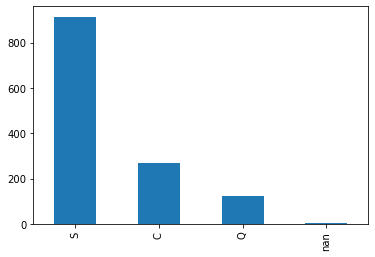

In [28]:
df['Embarked'].value_counts(dropna=False).plot(kind='bar');

In [29]:
#boş olan limanı en fazla veri olan S ile dolduruyoruz
df['Embarked']=df['Embarked'].fillna('S')

<AxesSubplot:xlabel='Embarked', ylabel='count'>

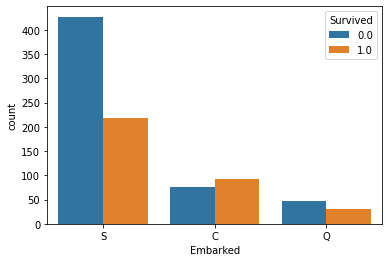

In [30]:
sns.countplot(x='Embarked',hue='Survived',data=df)

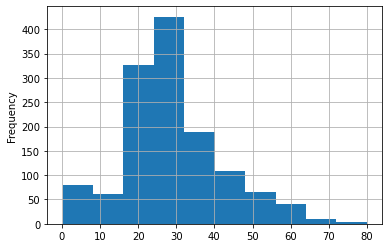

In [31]:
df['Age'].plot(kind='hist',bins=10).grid()

In [32]:
df['Family'].value_counts()

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: Family, dtype: int64

In [33]:
#Family saısısna göre yni sütun olışturduk
df['Single']=df['Family']<2
df['Small']=(df['Family']>1)&(df['Family']<5)
df['Medium']=(df['Family']>4)&(df['Family']<7)
df['Large']=df['Family']>6

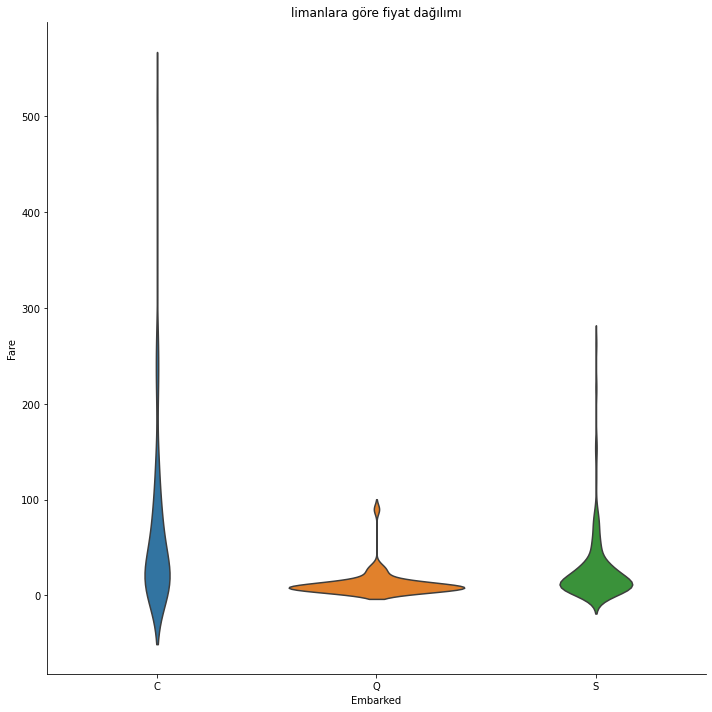

In [34]:
sns.catplot(x='Embarked', y='Fare', kind='violin',inner=None, data=df, height=10,order = ['C','Q','S'])
plt.title('limanlara göre fiyat dağılımı')
plt.tight_layout()

In [35]:
#isimin hayatta kalma ile ilgisi olmdığı için siliyoruz
del df['Name']

In [36]:
#passengerId ve bilet numaarasını hayatta kalam ile ilgisi olmadığı için onları df den çıkardık
df.drop(columns=['PassengerId', 'Ticket'],inplace=True)

In [37]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Senior,Family,Single,Small,Medium,Large
0,0.0,3,1,22.0,1,0,7.2500,S,Mr,0,2,False,True,False,False
1,1.0,1,0,38.0,1,0,71.2833,C,Mrs,0,2,False,True,False,False
2,1.0,3,0,26.0,0,0,7.9250,S,Miss,0,1,True,False,False,False
3,1.0,1,0,35.0,1,0,53.1000,S,Mrs,0,2,False,True,False,False
4,0.0,3,1,35.0,0,0,8.0500,S,Mr,0,1,True,False,False,False


In [38]:
#kategori değişkenlerine dummy variable uyguladık
df_dummies=pd.get_dummies(df,drop_first=True)

In [39]:
#veriyi train ve test olarak ayırdık. train ve test dosyalarında ilk 891 veri train kalan veri test verisiydi.
df_train=df_dummies[:891]
df_test=df_dummies[891:]

In [40]:
df_train.shape,df_test.shape

((891, 18), (418, 18))

In [41]:
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Senior,Family,Single,Small,Medium,Large,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs
0,0.0,3,1,22.0,1,0,7.2500,0,2,False,True,False,False,0,1,0,1,0
1,1.0,1,0,38.0,1,0,71.2833,0,2,False,True,False,False,0,0,0,0,1
2,1.0,3,0,26.0,0,0,7.9250,0,1,True,False,False,False,0,1,1,0,0
3,1.0,1,0,35.0,1,0,53.1000,0,2,False,True,False,False,0,1,0,0,1
4,0.0,3,1,35.0,0,0,8.0500,0,1,True,False,False,False,0,1,0,1,0


In [42]:
#train verisinden survived verisini sildik .Çünkü hedef verimiz bu traininin içinde yer almaması gerekiyor
del df_train['Survived']

In [43]:
y=df1['Survived']

In [47]:
#gbc=GradientBoostingClassifier()
#rfc=RandomForestClassifier()
#dtc=DecisionTreeClassifier()
#lr=LogisticRegression()
#kn=KNeighborsClassifier()
#g=GaussianNB()
#b=BernoulliNB()
#xgbc=XGBClassifier()
algorithms=[gbc,rfc,dtc,lr,kn,g,b,xgbc]
names=['GradientBoosting','RandomForest','DecisionTree','LogisticRegression','KNeighbours','GaussianNB','BernoulliNB','ExtraGradient']

In [56]:
def algo_test(X,Y,algorithms=algorithms, names=names):
    #fit the data
    for i in range(len(algorithms)):
        algorithms[i]=algorithms[i].fit(X,Y)
    #print metrics
    accuracy=[]
    precision=[]
    recall=[]
    f1=[]
    for i in range(len(algorithms)):
        accuracy.append(accuracy_score(Y,algorithms[i].predict(X)))
        
        precision.append(precision_score(Y, algorithms[i].predict(X)))
        
        recall.append(recall_score(Y, algorithms[i].predict(X)))
        
        f1.append(f1_score(Y, algorithms[i].predict(X)))
        
    metrics=pd.DataFrame(columns=['Accuracy','Precision','Recall','F1'],index=names)
    metrics['Accuracy']= accuracy
    metrics['Precision']= precision
    metrics['Recall']= recall
    metrics['F1']= f1
    return metrics.sort_values('F1',ascending=False)    

In [57]:
algo_test(df_train, y)

[22:30:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Accuracy,Precision,Recall,F1
RandomForest,0.979798,0.982143,0.964912,0.973451
DecisionTree,0.979798,0.993902,0.953216,0.973134
ExtraGradient,0.966330,0.975610,0.935673,0.955224
GradientBoosting,0.904602,0.907937,0.836257,0.870624
LogisticRegression,0.830527,0.793846,0.754386,0.773613
GaussianNB,0.808081,0.736842,0.777778,0.756757
KNeighbours,0.820426,0.797386,0.713450,0.753086
BernoulliNB,0.808081,0.746398,0.757310,0.751814


In [58]:
del df_test['Survived']

In [59]:
tahmin=dtc.predict(df_test)
tahmin

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [60]:
df_test.head(418)

,Pclass,Sex,Age,SibSp,Parch,Fare,Senior,Family,Single,Small,Medium,Large,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs
0,3,1,34.5,0,0,7.8292,0,1,True,False,False,False,1,0,0,1,0
1,3,0,47.0,1,0,7.0000,0,2,False,True,False,False,0,1,0,0,1
2,2,1,62.0,0,0,9.6875,0,1,True,False,False,False,1,0,0,1,0
3,3,1,27.0,0,0,8.6625,0,1,True,False,False,False,0,1,0,1,0
4,3,0,22.0,1,1,12.2875,0,3,False,True,False,False,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,1,29.0,0,0,8.0500,0,1,True,False,False,False,0,1,0,1,0
414,1,0,39.0,0,0,108.9000,0,1,True,False,False,False,0,0,0,0,1
415,3,1,38.5,0,0,7.2500,0,1,True,False,False,False,0,1,0,1,0
416,3,1,29.0,0,0,8.0500,0,1,True,False,False,False,0,1,0,1,0


In [61]:
sonuc=df2[['PassengerId']]

In [62]:
sonuc['Survived']=tahmin

In [63]:
sonuc.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,1
3,895,1
4,896,0


In [64]:
sonuc.shape

(418, 2)

In [65]:
sonuc.to_csv('Result.csv',index=False)